### M1 — Detecção de risco de AVC (Stroke)  
**Autores:** Maria Abreu & Ruben Ferreiro 
**Dataset:** `dataset.csv` (dados demográficos, clínicos e de hábitos)  
**Objetivo:** preparar os dados para prever a ocorrência de `stroke`, incluindo análise exploratória, limpeza, tratamento de dados e criação do pipeline de pré-processamento. 
A modelação, validação e avaliação serão realizadas no M2.

#### Resumo do fluxo do trabalho
1. Carregar e explorar os dados (EDA)
2. Identificar tipos de variáveis (numéricas, categóricas, ordinais, binárias)
3. Tratar valores ausentes e inconsistências
4. Codificar variáveis
5. Criar pipelines de pré-processamento
6. Separar dados em treino/validação/teste (estratificação)
7. Aplicar o pré-processamento aos dados

#### Variáveis principais (exemplo)
- `age`, `bmi`, `avg_glucose_level` — numéricas  
- `gender`, `work_type`, `Residence_type`, `ever_married` — categóricas nominais  
- `smoking_status` — ordinal  
- `hypertension`, `heart_disease` — binárias (0/1)  
- `stroke` — target (0/1)

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load dataset
df = pd.read_csv('dataset.csv')

# Drop unnecessary columns
df.drop('id', axis=1, inplace=True)

# Summary of data
df.describe(include='all')


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,43400,43400.000000,43400.000000,43400.000000,43400,43400,43400,43400.000000,41938.000000,30108,43400.000000
unique,3,NaN,NaN,NaN,2,5,2,NaN,NaN,3,NaN
top,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,25665,NaN,NaN,NaN,27938,24834,21756,NaN,NaN,16053,NaN
mean,NaN,42.217894,0.093571,0.047512,NaN,NaN,NaN,104.482750,28.605038,NaN,0.018041
std,NaN,22.519649,0.291235,0.212733,NaN,NaN,NaN,43.111751,7.770020,NaN,0.133103
min,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.000000,10.100000,NaN,0.000000
25%,NaN,24.000000,0.000000,0.000000,NaN,NaN,NaN,77.540000,23.200000,NaN,0.000000
50%,NaN,44.000000,0.000000,0.000000,NaN,NaN,NaN,91.580000,27.700000,NaN,0.000000
75%,NaN,60.000000,0.000000,0.000000,NaN,NaN,NaN,112.070000,32.900000,NaN,0.000000


In [41]:
display(df.head())
display(df.info())
print("Missing values por coluna:\n", df.isna().sum())
print("Distribuição da target:\n", df['stroke'].value_counts(normalize=True))

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                41938 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 3.6+ MB


None

Missing values por coluna:
 gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64
Distribuição da target:
 stroke
0    0.981959
1    0.018041
Name: proportion, dtype: float64


### Cell 2 — Separação dos conjuntos: treino / validação / teste

#### Objetivo
Criar conjuntos separados para treino, validação e teste, garantindo avaliações honestas e reprodutíveis.

#### Decisões e justificativa
- Divisão final recomendada: treino ≈ 60%, validação ≈ 20%, teste ≈ 20%.  
- Utilizar estratificação (`stratify`) para manter a proporção da target em cada subset.  
- Fixar `random_state` para reprodutibilidade.

#### Saídas esperadas / o que verificar
- Impressão das shapes de treino/val/test para confirmar proporções.  
- Verificar a distribuição da target em cada subset para garantir a estratificação.

#### Interpretação rápida
- Se as proporções da target diferirem muito entre subsets, rever o procedimento de split (usar estratify ou ajustar proporções).


In [42]:
# Split data: training/test sets
x = df.drop('stroke', axis=1)
y = df['stroke']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# Create validation set from the training portion
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

# Print shapes
print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)


Train: (26040, 10) Val: (8680, 10) Test: (8680, 10)


### Exploratory Visualizations

In this section, we visualize numeric and categorical variables to understand
their distribution, detect outliers, and observe relationships between features.


### Cell 3 — Definição dos grupos de features

#### Objetivo
Organizar as colunas por tipo (numéricas, categóricas nominais, ordinais, binárias) para aplicar transformações apropriadas.

#### O que este bloco faz
- Lista as features em grupos: numéricas, categóricas, ordinais e binárias.

#### Saídas esperadas / o que verificar
- Confirmar que todas as colunas listadas existem no DataFrame.  
- Preparar para atualizar estas listas se forem adicionadas features de engenharia (ex.: `age_group`, `bmi_cat`).

#### Interpretação rápida
- Mantém a consistência no pipeline; evita erros por nomes de colunas incorrectos antes de construir o preprocessor.

In [43]:
# Define feature types
numerical_features = ['age', 'bmi', 'avg_glucose_level']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type']
ordinal_features = ['smoking_status']
binary_features = ['hypertension', 'heart_disease']


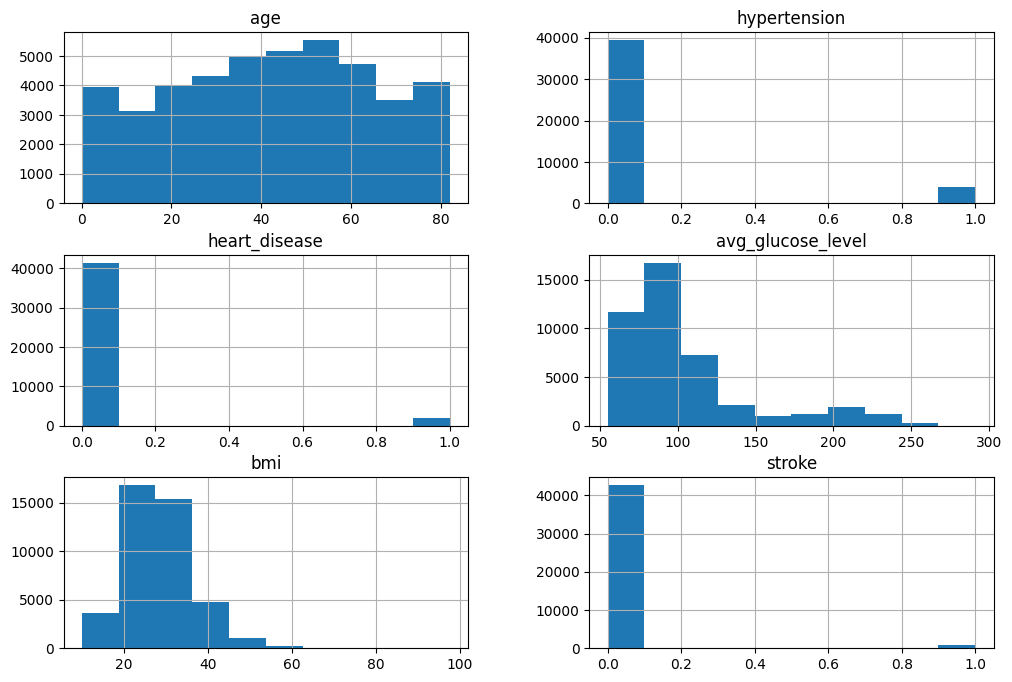

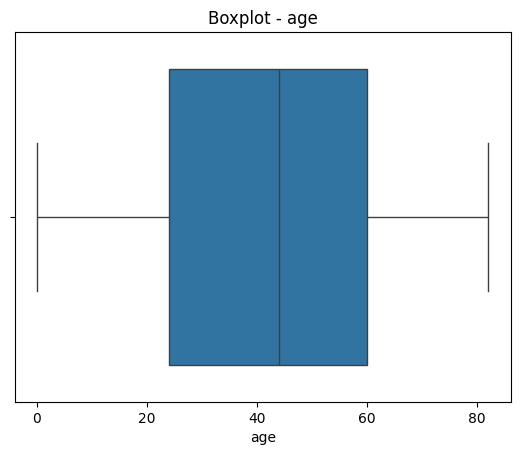

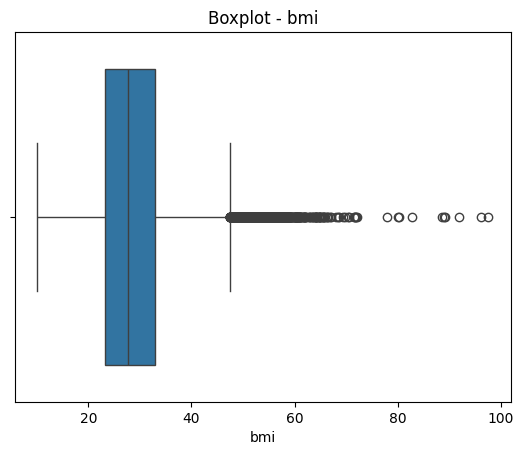

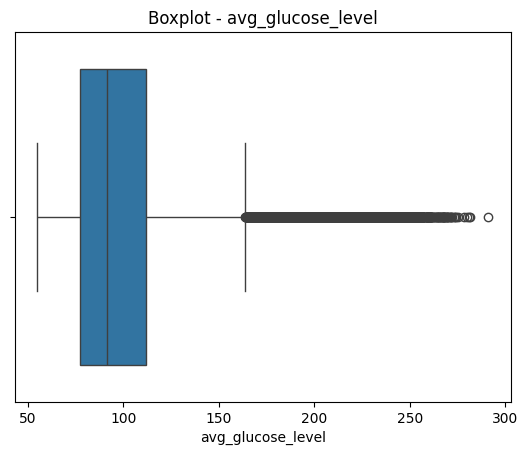

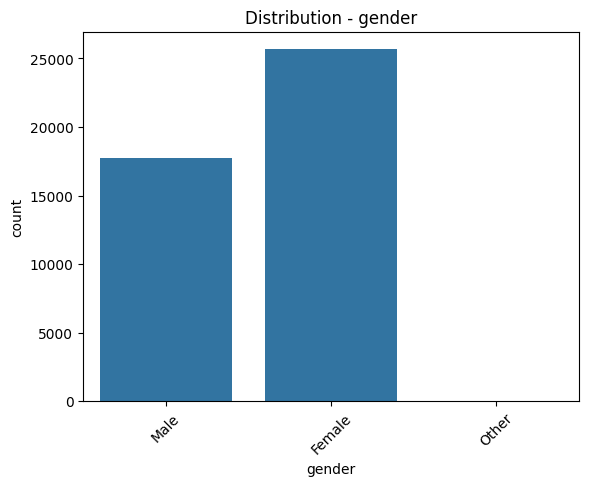

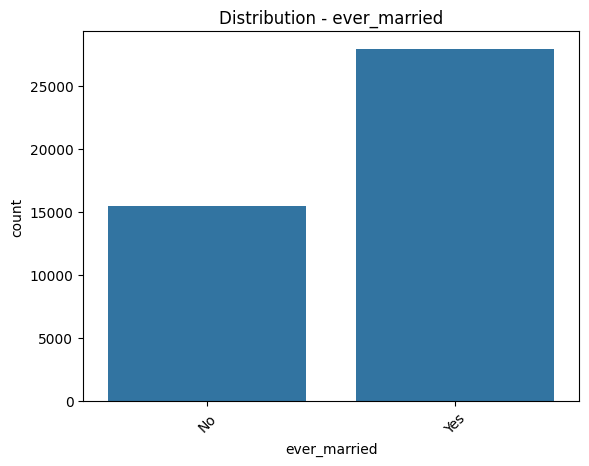

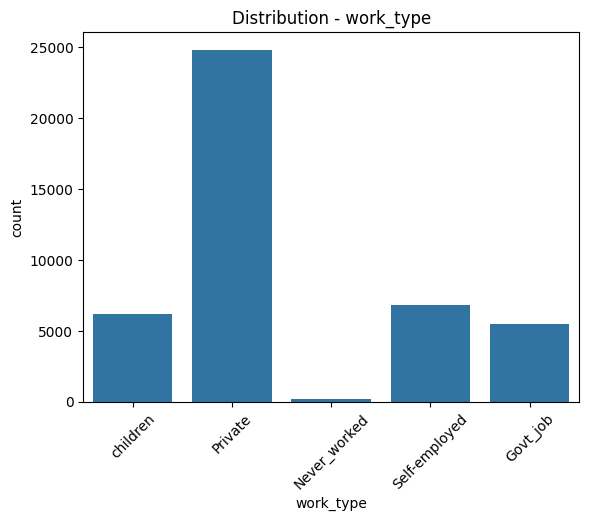

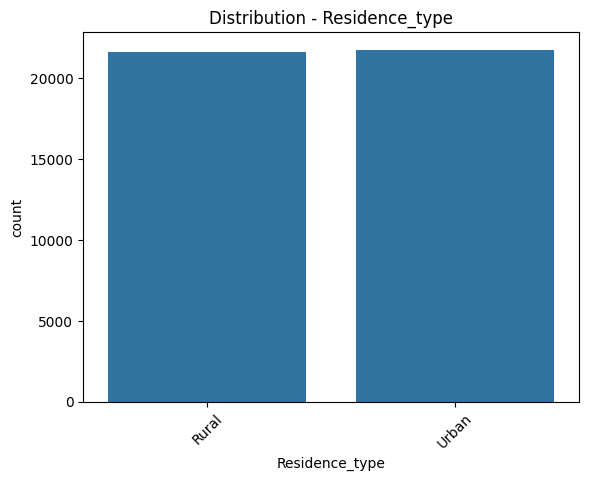

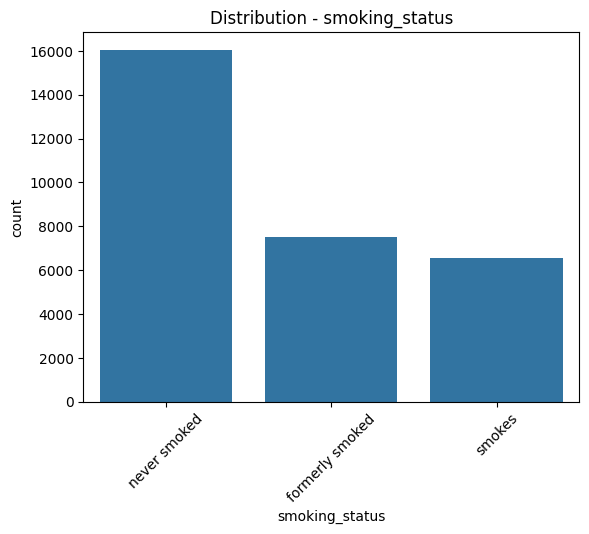

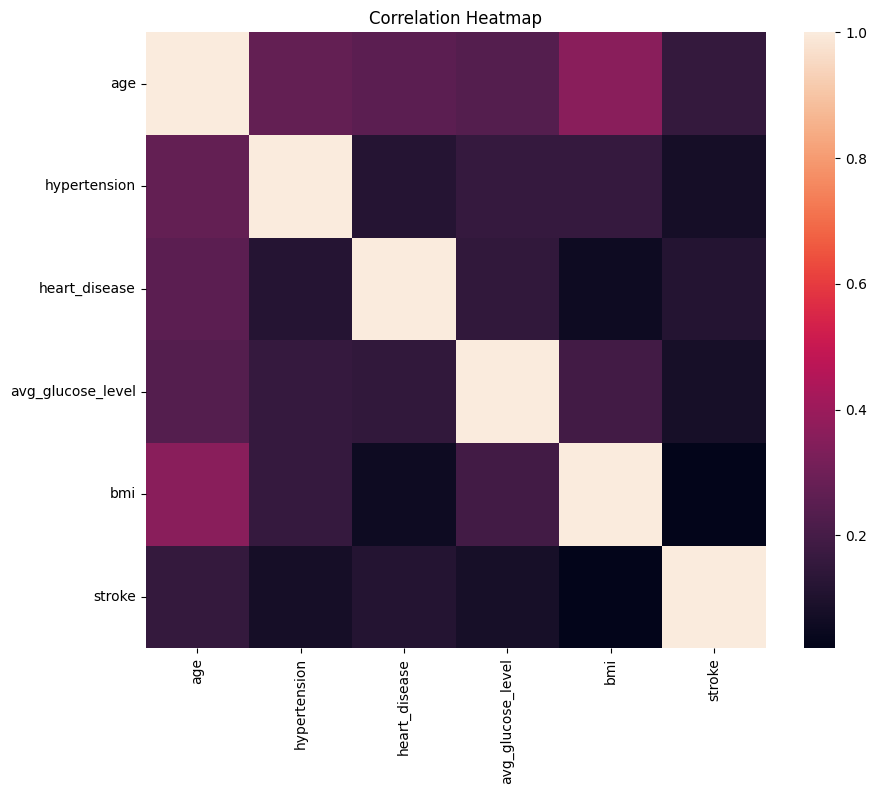

In [44]:
# Histograms
df.hist(figsize=(12,8))
plt.show()

# Boxplots numeric
for col in numerical_features:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot - {col}")
    plt.show()

# Category counts
for col in categorical_features + ordinal_features:
    sns.countplot(x=df[col])
    plt.title(f"Distribution - {col}")
    plt.xticks(rotation=45)
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=False)
plt.title("Correlation Heatmap")
plt.show()


### Cell 4 — Pré‑processamento: Missing data, Encoding e Scaling

#### Objetivo
Descrever e justificar as transformações aplicadas para obter um conjunto de features limpo e numérico, pronto para modelagem.

#### Decisões principais e justificativa
- Imputação:
  - Numéricas: mediana (robusta a outliers).  
  - Categóricas: moda (preserva categoria modal).  
  - Ordinal: imputar moda antes de codificar.
- Encoding:
  - Nominais: one-hot encoding (tratar categories desconhecidas).  
  - Ordinal: ordinal encoding com ordem predefinida; documentar valor para desconhecido.
- Scaling:
  - `StandardScaler()` para features numéricas quando necessário (SVM, KNN, regressão logística, redes neurais).

#### Saídas esperadas / o que verificar
- Contagem de NAs antes/depois da imputação.  
- Verificar o número de colunas resultantes após one-hot (pode aumentar dimensionalidade).  
- Documentar comportamentos (ex.: `-1` usado para unknown em ordinal).

#### Interpretação rápida
- Explicar por que cada escolha foi feita e como influencia os modelos (ex.: escalonamento melhora convergência em otimização).

In [45]:
# Order for ordinal features
smoking_order = ['never smoked', 'formerly smoked', 'smokes']

# Numeric pipeline (median imputation)
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # Add scaler if needed:
    # ('scaler', StandardScaler())
])

# Categorical pipeline (most frequent imputation + one-hot encoding)
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])


# Ordinal pipeline (most frequent imputation + ordinal encoding)
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('ordinal', OrdinalEncoder(categories=[smoking_order], handle_unknown='use_encoded_value', unknown_value=-1))
])


### Cell 5 — Combinação de pipelines.

#### Objetivo
Construir o preprocessor final e descrever o plano para engenharia de features, tratamento de classes desbalanceadas, treino e avaliação.

#### O que este bloco faz
- Integra pipelines por tipo de variável num `preprocessor` reutilizável.  
- Define próximas etapas e critérios de avaliação.


#### Saídas esperadas / o que verificar
- Lista final de features após pré-processamento/engenharia.  
- Relatório comparativo entre abordagens de balanceamento (métricas no val set).  
- Visualizações: matriz de confusão, curva ROC e tabelas de métricas consolidadas.

#### Interpretação rápida
- Para cada mudança (nova feature ou técnica de balanceamento) explique por que foi criada/selecionada e como afetou desempenho nas métricas mais relevantes.

In [46]:
# Combine the pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
        ('ord', ordinal_pipeline, ordinal_features),
        ('bin', 'passthrough', binary_features)
    ],
    remainder='drop'
)

# Done — preprocessor ready for model pipeline
preprocessor




,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


### Final Step: Apply Preprocessing (M1)
We now fit and apply the preprocessing pipeline to the training, validation, and test sets. 
This finalizes the data preparation stage required for M1.
Model training and performance evaluation will be completed in M2.


In [ ]:
from scipy.sparse import issparse

X_train_prepared = preprocessor.fit_transform(x_train)
X_val_prepared = preprocessor.transform(x_val)
X_test_prepared = preprocessor.transform(x_test)

print("Train shape before:", x_train.shape)
print("Train shape after preprocessing:", X_train_prepared.shape)

# Convert to dense if needed
if issparse(X_train_prepared):
    X_train_dense = X_train_prepared.toarray()
else:
    X_train_dense = X_train_prepared

# Convert dense matrix to DataFrame safely
X_train_df = pd.DataFrame(X_train_dense)

X_train_df.head()





Train shape before: (26040, 10)
Train shape after preprocessing: (26040, 18)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,61.0,24.7,55.99,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,79.0,25.0,260.91,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,78.0,27.7,118.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,69.0,25.0,87.07,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,8.0,16.3,70.87,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
